# Síntese de Experimento Raio x - Sem2

Grupo GD18 - Danilo Lessa Bernardineli e Rafael Mateus Marques

Bancada 1

Experimento realizado em 2018-06-14, das 14h até as 16h. Temperatura ambiente: 23º C. Pressão atmosférica: 945hPa

## Introdução

Com a adição filtros absorvedores aos procedimentos da ultima etapa do experimento, fez-se análise do espectro de emissão raio-x do Mo.

### Arranjo Experimental

* Apararato de Raio X Rontgengerat 5544 800
* Cristal de Sódio
* Cristal a determinar
* Filtros absorvedores (Zr, Mo, Ag, Al, In)
* Tubo de Mo

### Procedimentos

* Coloca-se o cristal de sódio dentro do aparato
* Coloca-se o filtro (Zr, Mo, Ag, Al, In) desejado frente ao detector
* Abre-se o software X-Ray Apparatus
* Coloca-se os parâmetros de medidas: $U = 35 kV$, $\beta_{min} = 2.5$, $\beta_{max} = 12.0$, $\Delta \beta = 0.1$, $\Delta t = 1$ e I=1.0mA
* Marca-se o "Scan" e "HV"
* Após a finalização da aquisição do espectro de emissão, salva-se o arquivo

## Resultados

Feitas as medições, carregamos os dados e fazemos um pré-processamento para visualizar eles com unidades de energia em keV bem como para assumir as incertezas nas intensidades nas medições como sendo dadas pela dispersão associada a uma distribuição de Poisson ($\sigma = \sqrt{N}$)

In [9]:
# Dependências

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.constants as ctes
import scipy.signal as sig
import scipy.stats as st
import uncertainties as unc
matplotlib.rcParams['figure.figsize'] = (15, 5)# Definições, parâmetros e constantes

In [11]:
# Definições de caminho e constantes
data_folder = "Sem2"
filepath = os.path.join(data_folder, "sem2_35kv_Ag.xry")
columns = ["S/F", "Zr", "Mo", "Al", "Ag"]
beta_min = 2.5 # deg
beta_max = 12 # deg
delta_beta = 0.1 # deg
d = 0.282 * 1e-9 # m
beta = np.arange(beta_min, beta_max + delta_beta, delta_beta)
beta_rad = np.radians(beta)
h = ctes.Planck
c = ctes.speed_of_light
e = ctes.eV
E = h * c / (2 * d * np.sin(beta_rad)) / (e * 1e3) #keV

In [12]:
# Carregar os dados para os diferentes filtros
data = pd.read_csv(filepath, skiprows=18, delimiter="\t", names=columns, index_col=False,
                   skipfooter=16, engine="python", na_values=["NAN"])
index_col = "E"
data[index_col]= E
index_col = data[index_col]
data.index = index_col
data = data[data.index < 35]
colunas_dados = ["S/F", "Zr", "Mo", "Al", "Ag"]
colunas_filtro = ["Zr", "Mo", "Al", "Ag"]

Os resultados brutos estão ilustradas na figura a seguir

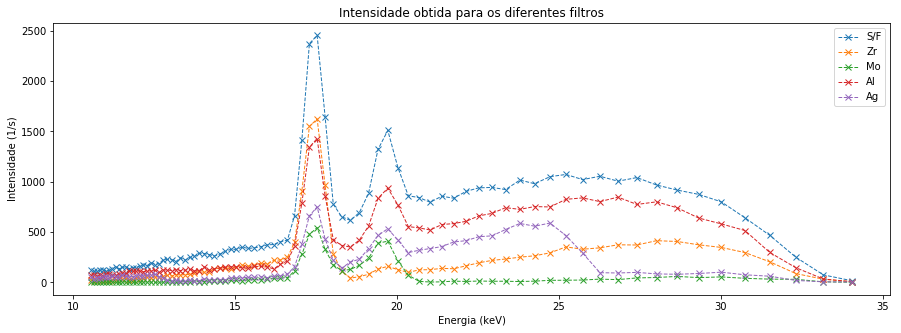

In [13]:
plt.title("Intensidade obtida para os diferentes filtros")
for filtro in colunas_dados:
    x = data.index
    y = data[filtro]
    plt.plot(x, y, 'x--', label=filtro, linewidth=1)
plt.legend()
plt.ylabel("Intensidade (1/s)")
plt.xlabel("Energia (keV)")
plt.show()

### Obtenção da transmitância e da espessura

Para analisar os dados, iniciamente calculamos a transmitância, que é definida pela razão entre a intensidade ao se utilizar um dos filtros pela intensidade da medição sem filtro. O resultado do logaritmo para os diferentes filtros é ilustrado no bloco seguinte.

Nota-se que apareceu degraus na transmitância em ~21keV para o Mo, ~18keV para o Zircônio e ~13/~26keV para o Ag, conforme esperado inicialmente

/home/danlessa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


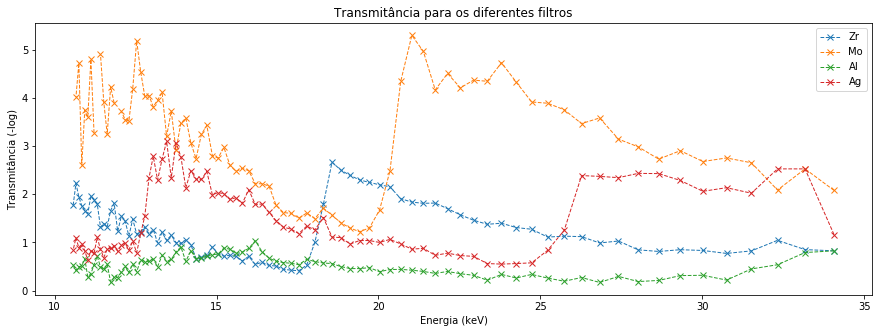

In [14]:
transmitancia = -np.log((data.loc[:, colunas_filtro].T / data.loc[:, "S/F"].values).T)
T = transmitancia
plt.title("Transmitância para os diferentes filtros")
for filtro in colunas_filtro:
    x = transmitancia.index
    y = transmitancia[filtro]
    plt.plot(x, y, 'x--', label=filtro, linewidth=1)
plt.legend()
plt.ylabel("Transmitância (-log)")
plt.xlabel("Energia (keV)")
plt.show()

Utilizando-se das localizações dos degraus no Mo e no Zircônio junto a tabela disponibilizada em aula para o coeficiente de atenuação $\mu$, é possível descobrir a espessura do material ao usar o fato de que $T = e^{-\mu x}$, onde x é a espessura do material e $T$ é a transmitância. (Referência: https://edisciplinas.usp.br/pluginfile.php/4322600/mod_resource/content/1/apresenta%C3%A7%C3%A3o-RX_2018.pdf)

Para o zircônio, o coeficiente de atenuação no degrau varia de 18 até 100 $\frac{cm^2}{g}$, enquanto que no Mo, o coeficiente varia de 17 até 90 $\frac{cm^2}{g}$. Portanto, calcula-se a espessura em ambos os limites para ambos os materiais e adota-se a média destes como sendo o valor verdadeiro

In [50]:
Intervalo_T = T[(T.index > 16) & (T.index < 24)]["Mo"]
T_min_Mo = np.min(Intervalo_T)
T_max_Mo = np.max(Intervalo_T)

x_min_Mo = T_min_Mo / (15 * 10.2e-3)
x_max_Mo = T_max_Mo / (80 * 10.2e-3)
x_Mo = (x_min_Mo + x_max_Mo) / 2
print("Espessura do [Mo] (cm): Média: {:.2g}, Mínimo: {:.2g}, Máximo: {:.2g}".format(x_Mo ,x_min_Mo, x_max_Mo))

Espessura do [Mo] (cm): Média: 7.2, Mínimo: 8, Máximo: 6.5


In [51]:
Intervalo_T = T[(T.index > 15) & (T.index < 20)]["Zr"]
T_min_Zr = np.min(Intervalo_T)
T_max_Zr = np.max(Intervalo_T)

x_min_Zr = T_min_Zr / (17 * 6.511e-3)
x_max_Zr = T_max_Zr / (90 * 6.511e-3)
x_Zr = (x_min_Zr + x_max_Zr) / 2
print("Espessura do [Zr] (cm): Média: {:.2g}, Mínimo: {:.2g}, Máximo: {:.2g}".format(x_Zr ,x_min_Zr, x_max_Zr))

Espessura do [Zr] (cm): Média: 4.1, Mínimo: 3.7, Máximo: 4.5


A espessura dos filtros estão portanto na ordem de 0.12cm para o Mo e 0.027cm para o Zr. Nota-se que tais números são 
aproximações grosseiras a serem refinadas em posterior análise


### Análise da difração de cristal



In [19]:
# Definições de caminho e constantes
data_folder = "Sem2"
filepath = os.path.join(data_folder, "sem2_35kv_cristalB_Zr.xry")
columns = ["S/F", "Zr"]
beta_min = 2.5 # deg
beta_max = 12 # deg
delta_beta = 0.1 # deg
d = 0.282 * 1e-9 # m
beta = np.arange(beta_min, beta_max + delta_beta, delta_beta)
beta_rad = np.radians(beta)
h = ctes.Planck
c = ctes.speed_of_light
e = ctes.eV
E = h * c / (2 * d * np.sin(beta_rad)) / (e * 1e3) #keV

In [20]:
# Carregar os dados para os diferentes filtros
data = pd.read_csv(filepath, skiprows=18, delimiter="\t", names=columns, index_col=False,
                   skipfooter=12, engine="python", na_values=["NAN"])
index_col = "beta"
data[index_col]= beta
index_col = data[index_col]
data.index = index_col
data = data[data.index < 35]
data.drop("beta", inplace=True, axis=1)

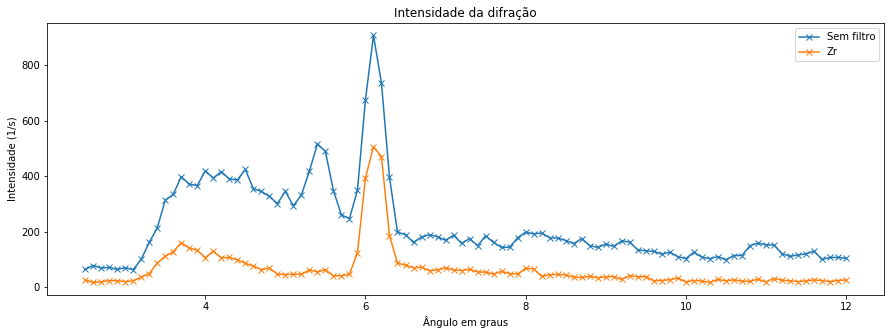

In [21]:
plt.title("Intensidade da difração")
plt.plot(data.index, data["S/F"], "x-", label="Sem filtro")
plt.plot(data.index, data["Zr"], "x-", label="Zr")
plt.ylabel("Intensidade (1/s)")
plt.xlabel("Ângulo em graus")
plt.legend()
plt.show()

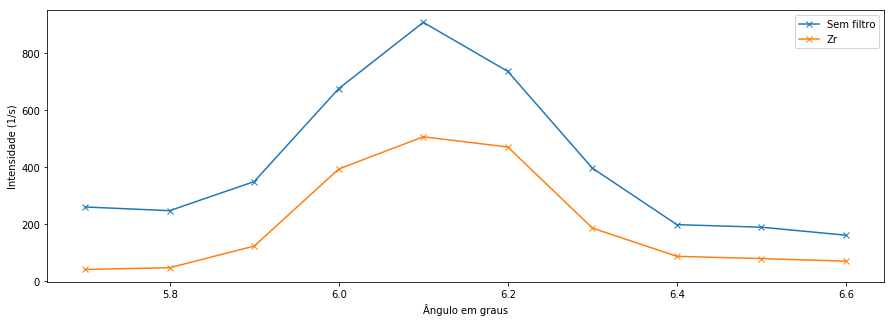

In [22]:
data = data[(data.index > 5.7) & (data.index < 6.7)]
plt.title("")
plt.plot(data.index, data["S/F"], "x-", label="Sem filtro")
plt.plot(data.index, data["Zr"], "x-", label="Zr")
plt.ylabel("Intensidade (1/s)")
plt.xlabel("Ângulo em graus")
plt.legend()
plt.show()

A distância interplanar é dada por 2.975 angstroms

In [23]:
angulo_pico = data["Zr"].idxmax() # º

rad_pico = np.radians(angulo_pico) # radianos
energia_pico = 19.61 * e * 1e3 #J
lambda_pico = h * c / energia_pico # m^-1

d = lambda_pico / (2 * np.sin(rad_pico)) * 1e10
print("d: {:.4g} Angstroms ".format(d))

d: 2.975 Angstroms 
